# Stocks data ingestion

In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-09-07 12:28:53,308 [info] loaded project stocks from MLRun DB


> <b> Steps </b>
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

## Creating a feature set and declaring the graph

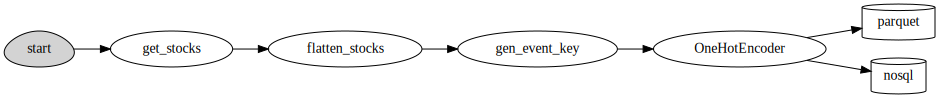

In [2]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
import yahoo_fin.stock_info as si

info_set = fstore.FeatureSet("stocks", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
n_tickers = 10


info_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker2onehot':{ticker:str(idx) for idx,ticker in enumerate(si.tickers_sp500()[:n_tickers])}}))\
    
# Setting default targets (nosql & parquet)
info_set.set_targets(with_defaults=True) 
info_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [ ]:
import os 
import datetime
# code must be present when ingestint locally
from src.stocks import *

# ingesting dummy (A MUST) 
name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(info_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':59,
                                      'end_delta':31,
                                      'interval':'5m',
                                      'n_stocks':n_tickers}),
              overwrite=True)

In [ ]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
info_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance', 'graphviz'], filename='src/stocks.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [ ]:
# Deploying
info_set_endpoint = fstore.deploy_ingestion_service(featureset=info_set, run_config=run_config)

## Testing ingestion service

In [ ]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(info_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':29,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':n_tickers})
t.text

## Creating scheduled mlrun job to invoke our function every time delta

In [ ]:
import datetime

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

body = {'ticker':['stocks'],
        'Datetime': now,
        'start_delta':1,
        'end_delta':0,
        'interval':'5m',
        'n_stocks':4}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':info_set_endpoint}, schedule='*/10 14-18 * * *')